## Importing Necessary Libraries and Making Initial Configurations
---

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import soundfile as sf

from glob import glob

import librosa
import IPython.display as ipd

import math

## Sampling and Plotting Functions
---

### Filename identifiers

 - Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

 - Vocal channel (01 = speech, 02 = song).
 
 - Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
 
 - Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
 
 - Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
 
 - Repetition (01 = 1st repetition, 02 = 2nd repetition).
 
 - Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

### RAVDESS Sampling Function

 - allows for customized querying of the RAVDESS dataset based on desired feature types


In [18]:
### DIRECTORY SPECIFIED IN PATH MUST HAVE THE SAME STRUCTURE AS ORIGINAL RAVDESS DATASET ###
# pass custom tuples in order to specify the desired feature types
# specifying only the path will include everything
def get_RAVDESS_sample(path, modality: tuple = (1,2,3),
                             voice_channel: tuple = (1,2),
                             emotion: tuple = tuple(range(1,9)),
                             intensity: tuple = (1,2),
                             statement: tuple = (1,2),
                             repetition: tuple = (1,2),
                             actor: tuple = tuple(range(1,25))):
    
    m = "".join(str(s) for s in modality)
    vc = "".join(str(s) for s in voice_channel)
    e = "".join(str(s) for s in emotion)
    i = "".join(str(s) for s in intensity)
    s = "".join(str(s) for s in statement)
    r = "".join(str(s) for s in repetition)

    actor = set(actor)
    
    dirs = []
    
    if(path[-1] == '/'):
        adirs = path+"Actor_*"
    else:
        adirs = path+"/Actor_*"
                
    for d in glob(adirs):
        if (int(d[-2]+d[-1]) in actor):
            dirs.append(d)

    files = []
    for d in dirs:
        d = d+"/"
        
        for f in glob(d+f"0[{m}]-0[{vc}]-0[{e}]-0[{i}]-0[{s}]-0[{r}]-*"):    
            files.append(f)
    
    audio = []
    for f in files:
        signal, sr = librosa.load(f, sr=None, mono=True)
        name = str.split(f, sep='/')[-1]
        audio.append([name, signal, sr])
    
    return audio

    

### Audio Signal Plotting Function

- uses a digital signal and its corresponding sample rate to plot an amplitude vs time graph

In [19]:
# signal plotting function
def plot_signal(signal, sample_rate, plot_title = "Audio Signal"):
    df = pd.DataFrame({
        'signals' : signal,
        'seconds' : [i/sample_rate for i in range(0, len(signal))]
    })
    df.plot(y="signals", x="seconds", figsize=(15,5), lw=0.1, title=plot_title, xlabel="seconds", ylabel="amplitude")

## Normalizing Sound Files by Average Power Level
---

The average power level of a digital signal is the sum of squares of all samples divided by the number of samples. To normalize, we determine the average power level of each audio file in the sample dataset and then calculate the overall mean of all averages. Each digital signal in the sample is then scaled up or down in order to match its power level to the overall mean.

### Loading all audio files

In [20]:
all_audio_files = get_RAVDESS_sample("./sound_files")

### Calculating Overall average power level for all audio files

In [21]:
# this will determine the overall average power level of the dataset
#   signals with P_avg below this overall average will be scaled up, else scaled down
total_avgs = 0
for a in all_audio_files:
    total_avgs += sum(a[1]**2)/len(a[1])
overall_P_avg = total_avgs/len(all_audio_files)
print(f"Overall average = {overall_P_avg}")

Overall average = 0.0008270979304005066


### Analyzing test audio file before and after scaling

In [22]:
# LOUD FILE
"03-01-03-02-02-01-10.wav"

for a in all_audio_files:
    if a[0] == "03-01-05-02-02-01-13.wav":
        loud_audio = copy.deepcopy(a)

# QUIET FILE
'03-01-02-02-02-01-05.wav'
for a in all_audio_files:
    if a[0] == "03-01-02-01-02-01-04.wav":
        quiet_audio = copy.deepcopy(a)

Average Power Level before scaling: 0.004623433824109984
Original Audio: 


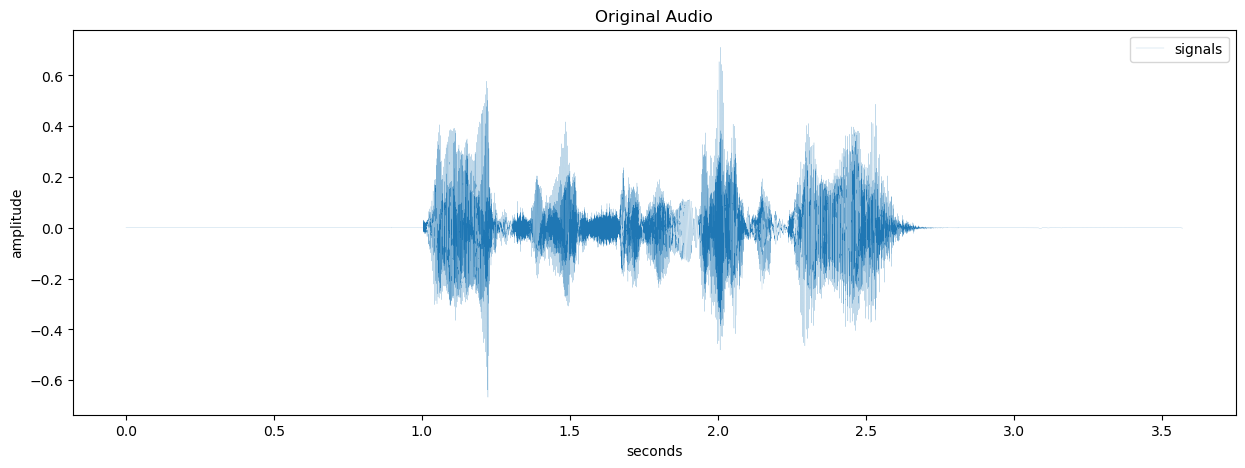

In [23]:
testfile = loud_audio
# plotting original audio
plot_signal(testfile[1],testfile[2], "Original Audio")
print(f"Average Power Level before scaling: {sum(testfile[1]**2)/len(testfile[1])}")
sf.write("./output/original_audio.wav", testfile[1], testfile[2])
print("Original Audio: ")
ipd.display(ipd.Audio("./output/original_audio.wav"))

In [24]:
# scaling audio file
scale_factor = math.sqrt( (overall_P_avg*len(testfile[1])) / (sum(testfile[1]**2)) )
testfile[1] *= scale_factor

Average Power Level after scaling: 0.0008270979948791471
Scaled Audio:


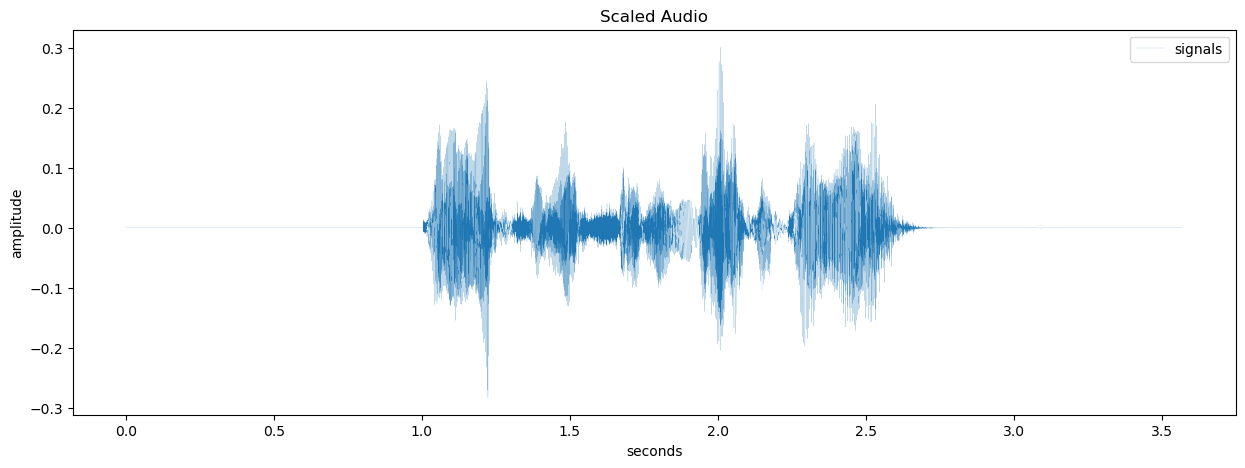

In [25]:
# plotting scaled audio
plot_signal(testfile[1],testfile[2], "Scaled Audio")
print(f"Average Power Level after scaling: {sum(testfile[1]**2)/len(testfile[1])}")
sf.write("./output/scaled_audio.wav", testfile[1], testfile[2])
print("Scaled Audio:")
ipd.Audio("./output/scaled_audio.wav")

## Experiment Sampling Method
---

The goal was to extract a sample from the dataset that was significantly smaller in size and computationally inexpensive, while preserving the original dataset's variability.

All emotional variations and intensities for the first repetition of a single statement were extracted. For statement 1, data came from the first half of the dataset (Actors 1-12), and for statement 2 data came from the second half (Actors 13-24). This ensured that variability across emotion type, emotional intensity and actor gender was retained. Furthermore, the inclusion of only one repitition for all statements and the consideration of only a single statement type for each actor resulted in a 4-fold reduction in sample size.

In [26]:
# all variations of statement 1 for the first 12 actors
dataset_sample = get_RAVDESS_sample("./sound_files", (3,), (1,), statement=(2,), repetition=(1,), actor=list(range(1,13)))

# all variations of statement 2 for the second 12 actors
dataset_sample.extend(get_RAVDESS_sample("./sound_files", (3,), (1,), statement=(2,), repetition=(1,), actor=list(range(13,25))))

# # printing number of audio files that will be processed
print(len(dataset_sample))

360


## Adding Noise
---

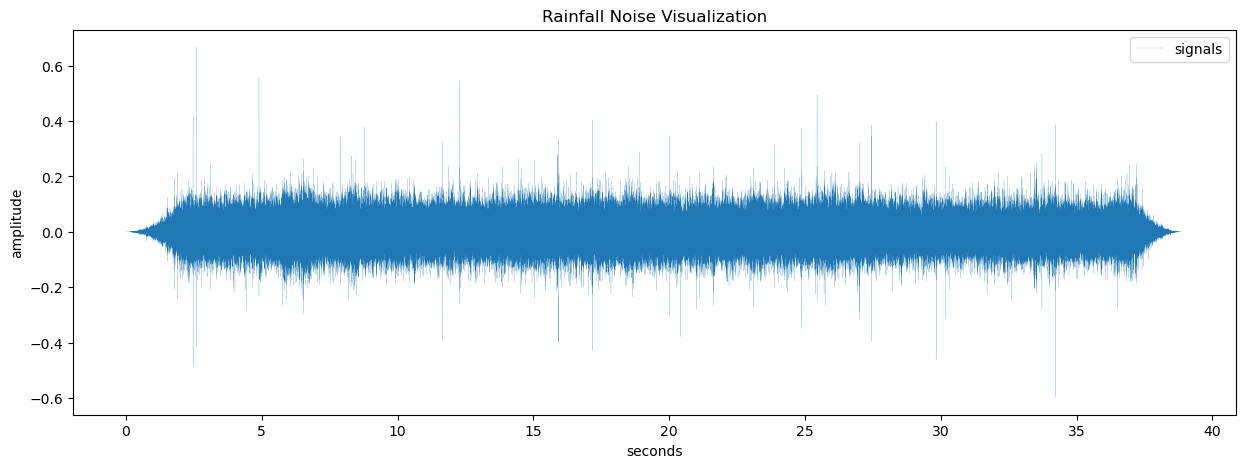

In [27]:
# rainfall noise downloaded from https://www.fesliyanstudios.com/royalty-free-sound-effects-download/rain-21
rain_noise_file = "./rainfall.mp3"
n, sr = librosa.load(rain_noise_file, sr=None, mono =True)
plot_signal(n, sr, "Rainfall Noise Visualization")
ipd.Audio(n, rate=sr)

In [28]:
# White noise generation function
def generate_white_noise_uniform(length):
    return np.random.uniform(-1,1,length)

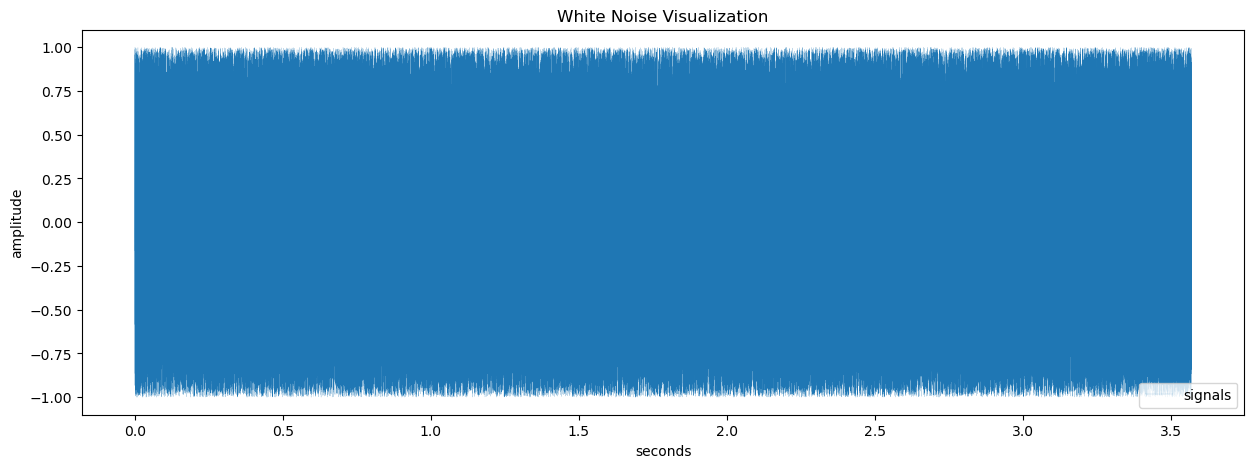

In [29]:
n = generate_white_noise_uniform(len(testfile[1]))
plot_signal(n, testfile[2], "White Noise Visualization")
ipd.Audio(n, rate=testfile[2])

In [30]:
# mixing function

def add_noise(noise_type, signal, snr=1):
    
    digital_signal = signal[1]
    sample_rate = signal[2]
    signal_len = len(digital_signal)
    filename = signal[0]
    signal_power = np.sum(digital_signal**2)/signal_len
    
    if noise_type == 'w':
        noise = generate_white_noise_uniform(signal_len)
    else:
        noise, _ = librosa.load(rain_noise_file, sr=None, mono =True)
        start = len(noise)//6
        end = start + signal_len
        noise = np.array(noise[start:end])
    
    noise_power = np.sum(noise**2)/signal_len
    noise_scale_factor = math.sqrt( (signal_power/noise_power)*(10**(-snr/10)) )
    
    noise *= noise_scale_factor
    noisy_audio = noise + digital_signal
    
    #normalizing noisy audio
    # scale_factor = math.sqrt(overall_P_avg*signal_len/sum(noise**2))
    # noisy_audio *= scale_factor
    
    return [filename, noisy_audio, sample_rate]
    

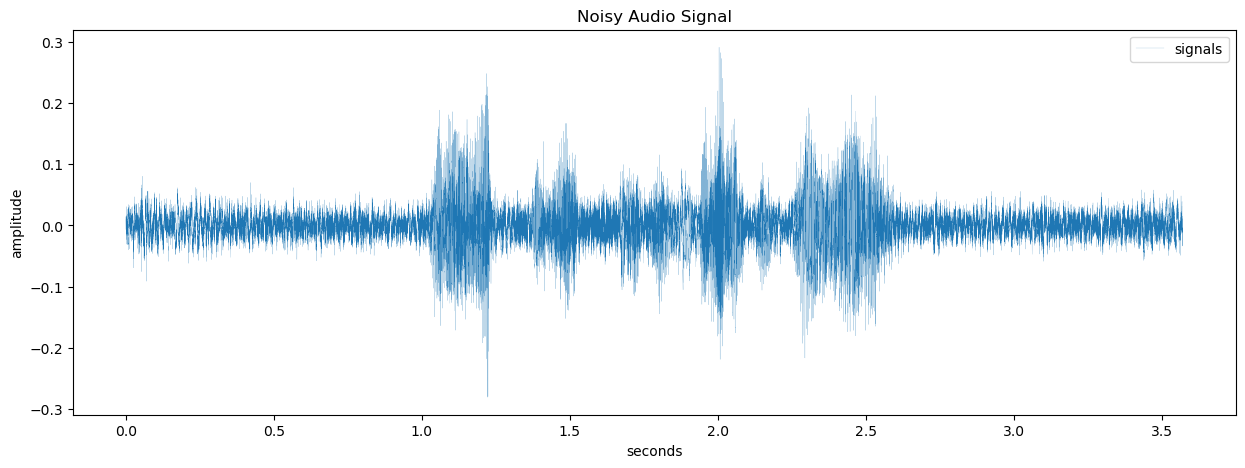

In [35]:
# requesting desired signal to noise ratio
snr = input("Please enter the desired signal to noise ratio:")
snr = int(snr)

# generating noisy audio
choice = input("Enter 'w' for for uniform white noise or 'r' for rain noise:")

noisy_audio = add_noise(choice, testfile, snr=snr)    
plot_signal(noisy_audio[1], noisy_audio[2], "Noisy Audio Signal")
sf.write("./output/noisy_audio.wav", noisy_audio[1], noisy_audio[2])
ipd.Audio("./output/noisy_audio.wav")

In [36]:
import statistics

def mean(d):
    return sum(d)/len(d)

def median(d):
    d = sorted(d)
    if(len(d)%2 == 0):
        lm = int(len(d)/2 - 1)
        rm = lm + 1
        return (d[lm] + d[rm]) / 2
    else:
        return d[math.ceil(len(d)/2)-1]

def mode(d):
    d = sorted(d)
    
    num = d[0]
    count = 1
    
    counts = []
    
    for i in range(1,len(d)):
        if d[i] == num:
            count +=1
        else:
            counts.append((num,count))
            num = d[i]
            count = 1
    
    if(num != counts[-1][0]):
        counts.append((num,count))
    
    counts = sorted(counts, key= lambda x: x[1])
    
    return counts[-1][0]

def var(d):
    u = mean(d)
    return sum([(u - i)**2 for i in d])/len(d)

def unb_var(d):
    x_bar = mean(d)
    return sum([(i - x_bar)**2 for i in d])/(len(d) - 1)

def std_dev(d, var):
    return math.sqrt(var(d))

def mad(d):
    u = mean(d)
    return sum([abs(i - u) for i in d])/len(d)

def z_score(d, u, s):
    return (d - u)/s

data = [5, 8, 11, 7, 9]
print(f"sorted: {sorted(data)}\n")

print(f"mean = {mean(data)}")
print(f"median = {median(data)}")
print(f"mode = {mode(data)}\n")

print(f"variance = {var(data)}")
print(f"unbiased variance = {unb_var(data)}")
print(f"mean absolute deviation = {mad(data)}\n")

print(f"standard deviation = {std_dev(data, var)}")
print(f"unbiased standard deviation = {std_dev(data, unb_var)}\n")

u = 8000*0.3 + 2000
s = 1500*0.3 + 2000
v = 37
print(f"value = {v}, std dev = {s}, mean = {u}, Number of std deviations from the mean (z-score): {z_score(v, u, s)}")

sorted: [5, 7, 8, 9, 11]

mean = 8.0
median = 8
mode = 11

variance = 4.0
unbiased variance = 5.0
mean absolute deviation = 1.6

standard deviation = 2.0
unbiased standard deviation = 2.23606797749979

value = 37, std dev = 2450.0, mean = 4400.0, Number of std deviations from the mean (z-score): -1.7808163265306123
